# Model agnostic grid operations using `xgcm`

In [1]:
import xarray as xr
import xgcm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker

import dask
import cmocean
import gsw
import cosima_cookbook as cc
import numpy as np

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

%matplotlib inline



In [2]:
# fire up a Dask cluster using the cores hosting the notebook
# If you need more oomph, NCI has instructions for creating a PBS cluster than can use multiple nodes
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()

2023-01-24 13:40:35,565 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/70723530.gadi-pbs/dask-worker-space/worker-fngu5t45', purging
2023-01-24 13:40:35,565 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/70723530.gadi-pbs/dask-worker-space/worker-3_8wxfio', purging
2023-01-24 13:40:35,566 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/70723530.gadi-pbs/dask-worker-space/worker-8e3ydh63', purging
2023-01-24 13:40:35,566 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/70723530.gadi-pbs/dask-worker-space/worker-6iexl9qs', purging


In [3]:
# either way, run this
client = Client(cluster)


In [4]:
cluster

In [5]:
print(client)

<Client: 'tcp://127.0.0.1:37013' processes=7 threads=7, memory=32.00 GiB>


# Start a COSIMA cookbook session

In [6]:
session = cc.database.create_session()#'/g/data/ik11/databases/daily/cosima_master_2022-08-30.db')

# reference density value:
rho_0 = 1035.0
g = 9.81



# MOM5 version

In [7]:
sim = '0.1RYF'

if sim == '0.1RYF':
    # RYF run with daily outputs
    #   for years 2170-2179, there is global daily temp, salt, pot_rho_1, uhrho_et, vhrho_nt, u, v, wt, dzt.
    expt = '01deg_jra55v13_ryf9091'
    start_time = '2170-01-01'
    end_time = '2170-1-31'

else:
    raise ValueError("'sim' not set correctly - notebook only works with 0.1RYF")


time_slice = slice(start_time, end_time)

## Load some coordinates

In [8]:
%%time
#load coordinates

ocean_grid = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc')

#load dzt
dzt = cc.querying.getvar(expt, 'dzt', session, start_time=start_time, end_time=end_time, ncfile='%daily%')


CPU times: user 6.89 s, sys: 1.98 s, total: 8.86 s
Wall time: 17.2 s


In [9]:

st_ocean = cc.querying.getvar(expt, 'st_ocean', session, start_time=start_time, end_time=end_time,  ncfile='%daily%')
ds_st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time,  ncfile='%daily%')


In [10]:
ocean_grid

<xarray.Dataset>
Dimensions:     (xt_ocean: 3600, yt_ocean: 2700, time: 1, xu_ocean: 3600,
                 yu_ocean: 2700)
Coordinates:
  * xt_ocean    (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean    (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time        (time) object 1900-04-01 00:00:00
  * xu_ocean    (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
    geolon_t    (yt_ocean, xt_ocean) float32 ...
    geolat_t    (yt_ocean, xt_ocean) float32 ...
    geolon_c    (yu_ocean, xu_ocean) float32 ...
    geolat_c    (yu_ocean, xu_ocean) float32 ...
Data variables:
    ht          (yt_ocean, xt_ocean) float32 ...
    hu          (yu_ocean, xu_ocean) float32 ...
    dxt         (yt_ocean, xt_ocean) float32 ...
    dyt         (yt_ocean, xt_ocean) float32 ...
    dxu         (yu_ocean, xu_ocean) float32 ...
    dyu         (yu_ocean, xu_ocean) float32 ...
    area_t      (yt_ocean, xt_ocean) float32 ...
    area_u      (yu_ocean, xu_ocean) float32 ...
    kmt         (yt_ocean, xt_ocean) float32 ...
    kmu         (yu_ocean, xu_ocean) float32 ...
    drag_coeff  (time, yu_ocean, xu_ocean) float32 ...
Attributes:
    filename:   ocean_grid.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1

## Load some variables

In [11]:
%%time

#load pot_rho_1
pot_rho_1 = cc.querying.getvar(expt,'pot_rho_1',session,start_time=start_time, end_time=end_time,ncfile='%daily%')

u = cc.querying.getvar(expt,'u',session,start_time=start_time, end_time=end_time,ncfile='%daily%')
v = cc.querying.getvar(expt,'v',session,start_time=start_time, end_time=end_time,ncfile='%daily%')

time = pot_rho_1.time


CPU times: user 11.2 s, sys: 521 ms, total: 11.8 s
Wall time: 16.2 s


The cookbook hides some of the grid data we need, so let's open a couple of NetCDF files directly.

In [12]:
u.ncfiles[0]

'/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1076/ocean/ocean_daily_3d_u.nc'

In [13]:
ocean_grid = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc')

ocean = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean.nc')

In [14]:
ocean

<xarray.Dataset>
Dimensions:                (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75,
                            st_edges_ocean: 76, time: 3, nv: 2, xu_ocean: 3600,
                            yu_ocean: 2700, sw_ocean: 75, sw_edges_ocean: 76,
                            grid_xu_ocean: 3600, grid_yt_ocean: 2700,
                            potrho: 80, potrho_edges: 81, grid_xt_ocean: 3600,
                            grid_yu_ocean: 2700, neutral: 80,
                            neutralrho_edges: 81)
Coordinates: (12/18)
  * xt_ocean               (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * yt_ocean               (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
  * st_ocean               (st_ocean) float64 0.5413 1.681 ... 5.709e+03
  * st_edges_ocean         (st_edges_ocean) float64 0.0 1.083 ... 5.809e+03
  * time                   (time) object 2170-04-16 00:00:00 ... 2170-06-16 0...
  * nv                     (nv) float64 1.0 2.0
    ...                     ...
  * potrho                 (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03
  * potrho_edges           (potrho_edges) float64 1.028e+03 ... 1.038e+03
  * grid_xt_ocean          (grid_xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * grid_yu_ocean          (grid_yu_ocean) float64 -81.09 -81.05 ... 89.96 90.0
  * neutral                (neutral) float64 1.028e+03 1.028e+03 ... 1.038e+03
  * neutralrho_edges       (neutralrho_edges) float64 1.028e+03 ... 1.038e+03
Data variables: (12/28)
    temp                   (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    pot_temp               (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    salt                   (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    age_global             (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    u                      (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    v                      (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    ...                     ...
    bih_fric_v             (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    u_dot_grad_vert_pv     (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    average_T1             (time) datetime64[ns] ...
    average_T2             (time) datetime64[ns] ...
    average_DT             (time) timedelta64[ns] ...
    time_bounds            (time, nv) timedelta64[ns] ...
Attributes:
    filename:   ocean.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1

## Create an `xgcm` grid object

In [15]:
ds = xr.merge([u, v, pot_rho_1, dzt])

In [16]:
ds

<xarray.Dataset>
Dimensions:    (xu_ocean: 3600, yu_ocean: 2700, st_ocean: 75, time: 273,
                xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * xu_ocean   (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean   (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time       (time) object 2170-01-01 12:00:00 ... 2170-09-30 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    u          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    v          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    pot_rho_1  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    dzt        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
Attributes: (12/13)
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    ...             ...
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration under th...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...

Add the coordinates and grid metrics to the dataset.

In [17]:
ds = ds.assign_coords({'st_ocean':ocean['st_ocean'], 'st_edges_ocean':ocean['st_edges_ocean'],
                      'dxu':ocean_grid['dxu'], 'dxt':ocean_grid['dxt'],
                      'dyu':ocean_grid['dyu'], 'dyt':ocean_grid['dyt'],
                      'area_t':ocean_grid['area_t'], 'area_u':ocean_grid['area_u'],})

In [18]:
ds

<xarray.Dataset>
Dimensions:         (xu_ocean: 3600, yu_ocean: 2700, st_ocean: 75, time: 273,
                     xt_ocean: 3600, yt_ocean: 2700, st_edges_ocean: 76)
Coordinates: (12/17)
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time            (time) object 2170-01-01 12:00:00 ... 2170-09-30 12:00:00
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
    ...              ...
    geolat_t        (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    dxt             (yt_ocean, xt_ocean) float32 ...
    dyu             (yu_ocean, xu_ocean) float32 ...
    dyt             (yt_ocean, xt_ocean) float32 ...
    area_t          (yt_ocean, xt_ocean) float32 ...
    area_u          (yu_ocean, xu_ocean) float32 ...
Data variables:
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    pot_rho_1       (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    dzt             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
Attributes: (12/13)
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    ...             ...
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration under th...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...

Where the `xgcm` magic happens!

Define the metrics and grid locations.

In [19]:

metrics = {
    ('X',): ['dxu', 'dxt'], # X distances
    ('Y',): ['dyu', 'dyt'], # Y distances
    ('Z',): ['dzt'], # Z distances (varies in time because of MOM's vetical coordinate)
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}
grid = xgcm.Grid(ds, coords={'X':{'center':'xt_ocean', 'right':'xu_ocean'},
                             'Y':{'center':'yt_ocean', 'right':'yu_ocean'},
                             'Z':{'center':'st_ocean', 'outer':'st_edges_ocean'}},
                 periodic = ['X'], metrics=metrics)



### Note on vertical cells
`st_ocean` is the tracer cell depth and `sw_ocean` is the vertical velocity cell depth. `st_edges_ocean` contains all the values in `sw_ocean` with a 0 appended to the beginning.

In [20]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
Z Axis (not periodic, boundary=None):
  * center   st_ocean --> outer
  * outer    st_edges_ocean --> center

## Calculate some things

### Relative vorticity

MOM5 computes relative vorticity as:

```
vorticity_z =
onehalf*(
(v(i,j,k) - v(i-1,j,k) )*Grd%dxtnr(i,j) &
+(v(i,j-1,k) - v(i-1,j-1,k))*Grd%dxtnr(i,j-1) &
-(u(i,j,k) - u(i,j-1,k) )*Grd%dyter(i,j) &
-(u(i-1,j,k) - u(i-1,j-1,k))*Grd%dyter(i-1,j)
)
```

See https://github.com/COSIMA/cosima-recipes/issues/13#issuecomment-311843830

In [21]:
rel_vort = grid.interp(grid.derivative(v, 'X'), 'Y') - grid.interp(grid.derivative(u, 'Y'), 'X')

In [22]:
rel_vort

<xarray.DataArray (time: 273, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<sub, shape=(273, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 2170-01-01 12:00:00 ... 2170-09-30 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [23]:
rel_vort_region = rel_vort.sel(time='2170-01-10').sel(st_ocean=10, method='nearest').sel(yt_ocean=slice(-90,-30)).compute()

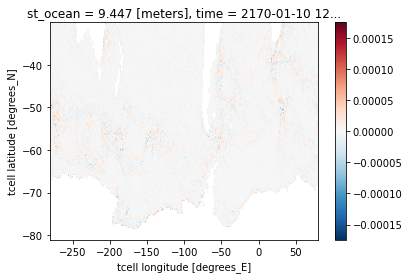

In [24]:

rel_vort_region.plot()

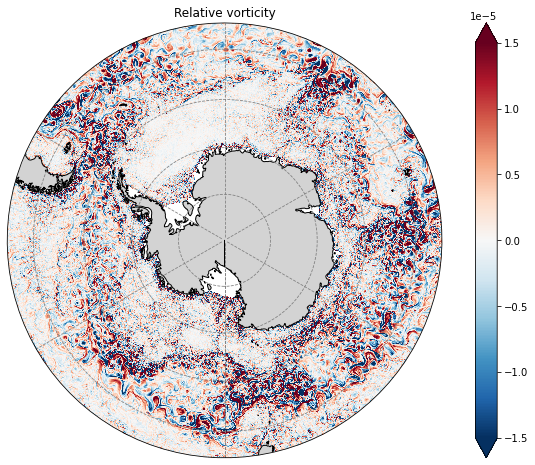

In [25]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -45], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

cf = rel_vort_region.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1.5e-5, vmax=1.5e-5, cmap='RdBu_r', extend='both')

plt.title('Relative vorticity');

### Barotropic streamfunction
Vertically integrate volume transport

$$
U_h = \int \left[ \int_{-H}^{0} [u] dz\right] dy
$$

In [26]:
psi = grid.cumint(grid.integrate(u, 'Z'), 'Y')

In [27]:
psi

<xarray.DataArray (time: 273, yt_ocean: 2700, xu_ocean: 3600)>
dask.array<concatenate, shape=(273, 2700, 3600), dtype=float32, chunksize=(1, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * time      (time) object 2170-01-01 12:00:00 ... 2170-09-30 12:00:00
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [28]:
psi_region = psi.sel(time='2170-01-10').sel(yt_ocean=slice(-90,-30)).compute()

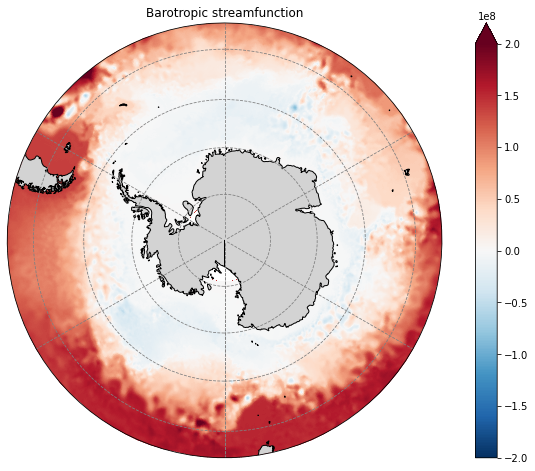

In [29]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -45], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

cf = psi_region.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-200e6, vmax=200e6, cmap='RdBu_r', extend='max')

plt.title('Barotropic streamfunction');

# Make it work with MOM6

In [30]:
# these are the values used by MOM5

Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

In [31]:
foo = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-v2/output090/19980701.ocean_daily.nc')

In [32]:
foo

<xarray.Dataset>
Dimensions:     (xh: 7200, yh: 1690, time: 31, nv: 2)
Coordinates:
  * xh          (xh) float64 -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh          (yh) float64 -81.1 -81.08 -81.06 -81.03 ... -37.16 -37.12 -37.08
  * time        (time) object 1998-07-01 12:00:00 ... 1998-07-31 12:00:00
  * nv          (nv) float64 1.0 2.0
Data variables:
    zos         (time, yh, xh) float32 ...
    tos         (time, yh, xh) float32 ...
    sos         (time, yh, xh) float32 ...
    tob         (time, yh, xh) float32 ...
    sob         (time, yh, xh) float32 ...
    mlotst      (time, yh, xh) float32 ...
    speed       (time, yh, xh) float32 ...
    average_T1  (time) datetime64[ns] ...
    average_T2  (time) datetime64[ns] ...
    average_DT  (time) timedelta64[ns] ...
    time_bnds   (time, nv) timedelta64[ns] ...
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19980701.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [33]:
# load simulation data and rename some axes
ds_panant = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-v2/restart095/MOM.res*.nc', chunks='auto')
ds_panant = ds_panant.rename({'latq':'yq'}).rename({'lath':'yh'}).rename({'lonq':'xq'}).rename({'lonh':'xh'})

# load grid data
ds_grid = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-v2/output000/19910101.ocean_static.nc', chunks='auto')

# merge the two 
ds_panant = xr.merge([ds_panant, ds_grid])

# xgcm doesn't work well when fields are defined on the 'outer' position in axes, so drop one row and one column from these fields
# to shift them to 'left'
ds_panant = ds_panant.drop_sel(xq=ds_panant.xq[-1])
ds_panant = ds_panant.drop_sel(yq=ds_panant.yq[-1])

# define grid metrics for automagic differentiation
metrics = {
    ('X',): ['dxCu', 'dxCv'],
    ('Y',): ['dyCu', 'dyCv'],
            }

grid = xgcm.Grid(ds_panant, coords={'X':{'center':'xh', 'left':'xq'},
                             'Y':{'center':'yh', 'left':'yq',},
                             'Z':{'center':'Layer', 'outer':'Interface'}}, periodic = ['X'],
                metrics=metrics)

In [34]:
# calculate relative vorticity

zeta = grid.derivative(ds_panant.v, 'X') - grid.derivative(ds_panant.u, 'Y')

# assign name and units
zeta = zeta.rename('Relative Vorticity')
zeta.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
zeta.attrs['units'] = 's-1'



In [35]:
# calculate Coriolis
# (there is a Coriolis field in the grid info, but I found it easier to calculate like this and broadcast

f_panant = 2 * Ω * np.sin(np.deg2rad(ds_panant['yq'])) # convert lat in radians
f_panant = f_panant.rename('Coriolis')
f_panant.attrs['long_name'] = 'Coriolis parameter'
f_panant.attrs['units'] = 's-1'

# f_panant = grid.interp(grid.interp(f, 'X'), 'Y', boundary='extend')


In [36]:

%%time
zeta.load()
Ro_panant = zeta/f_panant

CPU times: user 16.1 s, sys: 11.6 s, total: 27.7 s
Wall time: 1min 11s


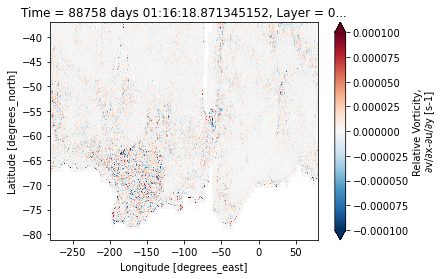

In [37]:
zeta.sel(Layer=0, method='nearest').plot(vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')


CPU times: user 7.98 s, sys: 907 ms, total: 8.89 s
Wall time: 7.64 s


Text(0, 0.5, 'Rossby number, (∂v/∂x-∂u/∂y)/f')

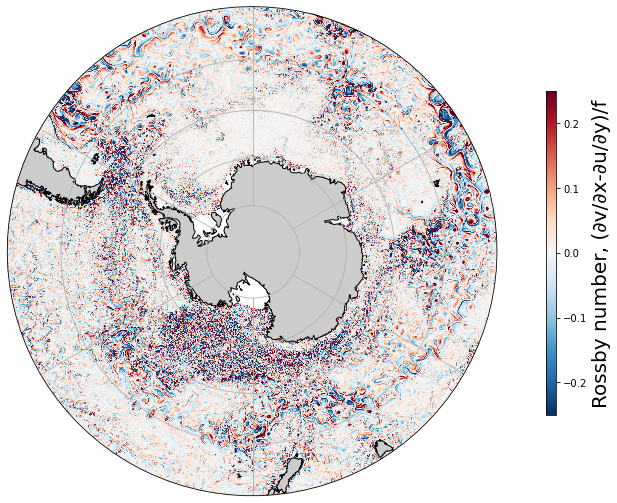

In [38]:
%%time

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = Ro_panant.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-0.25, vmax=0.25, cmap='RdBu_r')
ax.set_title('')

gl = ax.gridlines(ylim=(-80,80), ylocs=[-80, -70, -60, -50, -40, -30]) #y_inline=True, 
# crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='black', alpha=0.5, linestyle='--')
# gl.xlabels_top = False
# gl.ylabels_left = False
# gl.xlines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}



ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Rossby number, (∂v/∂x-∂u/∂y)/f', fontsize=20);